## Deep Learning Basics

In this tutorial we we will implement a toy deep learning framework, to rapidly create neural network models. It should have some flexibilty and will be implemented so that new modules can be added and replaced just like in modern deep learning frameworks. We will be implementing some types of basic layers. We will also explore pytorch's nn package and see how pytorch accomplishes this goal and what are the extras that pytorch offers.


### 1. Cleaner mini-batch-capable Linear + Softmax classifier


In the previous assignment, we provided a basic implementation of a linear softmax classifier. In this assignment we will use this as a starting point for our deep learning library. 

**Softmax + Negative Log-Likelihood:** First we will re-implement the (softmax + negative log likelihood loss) computation, and its gradient computation. But we will additionally support batches of inputs and labels. 


In [98]:
import torch

# This class combines Softmax + Negative-log likelihood loss.
# Similar to the previous lab, but this implementation works for 
# batches of inputs and not just individual input vectors. 
# Here "inputs" is batchSize x sizePredictionScores, and
#      "labels" is a vector of size batchSize.
class toynn_CrossEntropyLoss(object): 
  
    # Forward pass: -log softmax(input_{label})
    def forward(self, scores, labels):
      
        # 1. Computing the softmax: exp(x) / sum (exp(x))
        max_val = scores.max()  # This is to avoid variable overflows.
        exp_inputs = (scores - max_val).exp()
        # This is different than in the previous lab. Avoiding for loops here.
        denominators = exp_inputs.sum(1).repeat(scores.size(1), 1).t()
        self.predictions = torch.mul(exp_inputs, 1 / denominators)
        
        # 2. Computing the loss: -log(y_label).
        # Check what gather does. Just avoiding another for loop here.
        return -self.predictions.log().gather(1, labels.view(-1, 1)).mean()
    
    # Backward pass: y_hat - y
    def backward(self, scores, labels):
      
        # Here we avoid computing softmax again in backward pass.
        grad_inputs = self.predictions.clone()
        
        # Ok, Here we will use a for loop (but it is avoidable too).
        for i in range(0, scores.size(0)):
            grad_inputs[i][labels[i]] = grad_inputs[i][labels[i]] - 1
            
        return grad_inputs 
      
      
# Let's verify if the above seems to be Okay.
batchSize = 32
mock_scores = torch.zeros(batchSize, 10).normal_(0, 0.1)
mock_labels = torch.zeros(batchSize, 1, dtype=torch.long).fill_(3)

loss_fn = toynn_CrossEntropyLoss()

loss = loss_fn.forward(mock_scores, mock_labels)
mock_scores_grads = loss_fn.backward(mock_scores, mock_labels)

print("Input predictions: ", mock_scores.shape)
print("Input labels: ", mock_labels.shape)
print("Output loss: ", loss.item())
print("Input prediction gradients: ", mock_scores_grads.shape)

Input predictions:  torch.Size([32, 10])
Input labels:  torch.Size([32, 1])
Output loss:  2.301769256591797
Input prediction gradients:  torch.Size([32, 10])



**Linear Transformation:**  Next, we will re-implement the linear transformation computation $y=Wx+b$, and its gradient computation. But we will additionally support batches of inputs and labels. Making a batched implementation of this layer is easier because the only change is that now we have matrix-matrix multiplications as opposed to vector-matrix multiplications. Additionally, we will support returning the gradients with respect to the inputs to the linear transformation ($\partial \ell / \partial x_j$). Notice that in our previous assignment we were only concerned with computing $\partial \ell / \partial w_{ij}$ and  $\partial \ell / \partial b_i$ (gradients for the parameters).

In [99]:
class toynn_Linear(object):
    def __init__(self, numInputs, numOutputs):
        # Allocate tensors for the weight and bias parameters.
        self.weight = torch.Tensor(numInputs, numOutputs).normal_(0, 0.01)
        self.weight_grads = torch.Tensor(numInputs, numOutputs)
        self.bias = torch.Tensor(numOutputs).zero_()
        self.bias_grads = torch.Tensor(numOutputs)
    
    # Forward pass, inputs is a matrix of size batchSize x numInputs.
    # Notice that compared to the previous assignment, each input vector
    # is a row in this matrix.
    def forward(self, inputs):
        # This one needs no change, it just becomes 
        # a matrix x matrix multiplication
        # as opposed to just vector x matrix multiplication as we had before.
        return torch.matmul(inputs, self.weight) + self.bias
    
    # Backward pass, in addition to compute gradients for the weight and bias.
    # It has to compute gradients with respect to inputs. 
    def backward(self, inputs, scores_grads):
        self.weight_grads = torch.matmul(inputs.t(), scores_grads)
        self.bias_grads = scores_grads.sum(0)
        return torch.matmul(scores_grads, self.weight.t())

# Input: batchSize x numInputs.
numInputs = 1 * 28 * 28
mock_inputs = torch.Tensor(batchSize, numInputs).normal_(0, 0.1)

# Create the linear object to use.
linear = toynn_Linear(numInputs, 10)

# Forward and Backward passes:
scores = linear.forward(mock_inputs)
mock_inputs_grads = linear.backward(mock_inputs, mock_scores_grads)

print("Input x: ", mock_inputs.shape)
print("Weights W: ", linear.weight.shape)
print("Biases b: ", linear.bias.shape)
print("Outputs: ", scores.shape)
print("dL / dx: ", mock_inputs_grads.shape)

Input x:  torch.Size([32, 784])
Weights W:  torch.Size([784, 10])
Biases b:  torch.Size([10])
Outputs:  torch.Size([32, 10])
dL / dx:  torch.Size([32, 784])


We are finished with a cleaner implementation of the linear + softmax + negative log-likelihood classifier that we implemented for the previous assignment: (1) It supports batches,  (2) the functions for forward and backward are nicely packaged in a python class, (3) the weight and bias matrices (as well as weight_grad and bias_grad matrices) are nicely created and initialized in the constructor of the toynn_Linear class, (4) the Linear class also computes $\partial \ell / \partial x_j$'s, which will be useful to stack layers in order to train deeper models.

### 2. Mini-batch SGD on FashionMNIST


Given the newly implemented toynn_CrossEntropyLoss and toynn_Linear classes, let's train a classifier which is exactly the same as in the previous assignment, but now we can use batches of examples, as opposed to single examples during training with Stochastic (mini-batch) Gradient Descent (SGD). There are a few changes to make to the code from the previous assignment

In [16]:
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST

# Removes, the need to call F.to_image ourselves.
# Also, please look up what transforms.Normalize does.
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), 
                                                    (0.5, 0.5, 0.5))])

# Load the training, and validation datasets.
trainset = FashionMNIST(root = './data', train = True, transform = transform, download = True)
valset = FashionMNIST(root = './data', train = False, transform = transform, download = True)

# NEW: Pytorch DataLoader for iterating over batches.
batchSize = 100

# Shuffling is needed in case dataset is not shuffled by default.
train_loader = torch.utils.data.DataLoader(dataset = trainset,
                                           batch_size = batchSize,
                                           shuffle = True)
# We don't need to bach the validation set but let's do it anyway.
val_loader = torch.utils.data.DataLoader(dataset = valset,
                                         batch_size = batchSize,
                                         shuffle = False) # No need.

# Define a learning rate. 
learningRate = 1e-4

# Define number of epochs.
N = 5

# Create the model.
loss_fn = toynn_CrossEntropyLoss()
linear_fn = toynn_Linear(1 * 28 * 28, 10)


# log accuracies and losses.
train_accuracies = []; val_accuracies = []
train_losses = []; val_losses = []

# Training loop. Please make sure you understand every single line of code below.
# Go back to some of the previous steps in this lab if necessary.
for epoch in range(0, N):
    correct = 0.0
    cum_loss = 0.0
    
    # Make a pass over the training data.
    for (i, (inputs, labels)) in enumerate(train_loader):
        inputs = inputs.view(batchSize, 1 * 28 * 28)
        
        # Forward pass. (Prediction stage)
        scores = linear_fn.forward(inputs)
        cum_loss += loss_fn.forward(scores, labels).item()
        
        # Count how many correct in this batch.
        max_scores, max_labels = scores.max(1)
        correct += (max_labels == labels).sum().item()
        
        #Backward pass. (Gradient computation stage)
        scores_grads = loss_fn.backward(scores, labels)
        grad_inputs = linear_fn.backward(inputs, scores_grads)
        
        # Parameter updates (SGD step).
        linear_fn.weight.add_(-learningRate, linear_fn.weight_grads)
        linear_fn.bias.add_(-learningRate, linear_fn.bias_grads)
        
        # Logging the current results on training.
        if (i + 1) % 100 == 0:
            print('Train-epoch %d. Iteration %05d, Avg-Loss: %.4f, Accuracy: %.4f' % 
                  (epoch, i + 1, cum_loss / (i + 1), correct / (i * batchSize + 1)))
    
    train_accuracies.append(correct / len(trainset))
    train_losses.append(cum_loss / len(trainset))
    
    
    # Make a pass over the validation data.
    correct = 0.0
    cum_loss = 0.0
    for (i, (inputs, labels)) in enumerate(val_loader):
        inputs = inputs.view(batchSize, 1 * 28 * 28)
        
        # Forward pass. (Prediction stage)
        scores = linear_fn.forward(inputs)
        cum_loss += loss_fn.forward(scores, labels).item()
        
         # Count how many correct in this batch.
        max_scores, max_labels = scores.max(1)
        correct += (max_labels == labels).sum().item()
          
    val_accuracies.append(correct / len(valset))
    val_losses.append(cum_loss / (i + 1))
            
    # Logging the current results on validation.
    print('Validation-epoch %d. Avg-Loss: %.4f, Accuracy: %.4f' % 
          (epoch, cum_loss / (i + 1), correct / len(valset)))

Train-epoch 0. Iteration 00100, Avg-Loss: 1.1319, Accuracy: 0.6881
Train-epoch 0. Iteration 00200, Avg-Loss: 0.9479, Accuracy: 0.7210
Train-epoch 0. Iteration 00300, Avg-Loss: 0.8595, Accuracy: 0.7377
Train-epoch 0. Iteration 00400, Avg-Loss: 0.8033, Accuracy: 0.7514
Train-epoch 0. Iteration 00500, Avg-Loss: 0.7660, Accuracy: 0.7590
Train-epoch 0. Iteration 00600, Avg-Loss: 0.7348, Accuracy: 0.7675
Validation-epoch 0. Avg-Loss: 0.5973, Accuracy: 0.7948
Train-epoch 1. Iteration 00100, Avg-Loss: 0.5757, Accuracy: 0.8152
Train-epoch 1. Iteration 00200, Avg-Loss: 0.5673, Accuracy: 0.8125
Train-epoch 1. Iteration 00300, Avg-Loss: 0.5580, Accuracy: 0.8139
Train-epoch 1. Iteration 00400, Avg-Loss: 0.5553, Accuracy: 0.8144
Train-epoch 1. Iteration 00500, Avg-Loss: 0.5514, Accuracy: 0.8143
Train-epoch 1. Iteration 00600, Avg-Loss: 0.5466, Accuracy: 0.8150
Validation-epoch 1. Avg-Loss: 0.5475, Accuracy: 0.8106
Train-epoch 2. Iteration 00100, Avg-Loss: 0.5270, Accuracy: 0.8262
Train-epoch 2. Iter

We achieved an accuracy of 80% a lot faster than in the previous assignment, in fact we reached almost 83% in the same amount of epochs as before, so it seems mini-batching is helping to some extent. Try experimenting with different batch sizes and learning rates. Batch-size and learning rate are two hyper-parameters that are related in the optimization process, and is a current line of active research. For instance, under deep learning models, larger batch sizes do not offer as good generalization as smaller batches, which is bad because it is easier to parallelize code when using larger batch sizes. Also, a common strategy during training is to reduce (decay) the learning rate, as the training progresses to the later epochs, but a recent paper proposed to increase the batch size instead (for more, see: https://arxiv.org/abs/1711.00489 ). Probably for small datasets, keeping the learning rate fixed and batch size fixed will be fine, but as one moves to larger datasets, and deeper models, it becomes crucial to use some more advanced strategies.

### 3. The Rectified Linear Unit (ReLU) Activation Function.


We are close to implementing a neural network, we can accomplish this by stacking a linear operation on top of a Rectified Linear Unit (ReLU) activation, another linear operation, and the softmax + negative log likelihood loss. This is all it takes to create simple neural network with one hidden layer. First, let's implement the ReLU layer as we implemented the linear layer. 

In [17]:
class toynn_ReLU(object):
  
    # Forward operation: f(x_i) = max(0, x_i)
    def forward(self, inputs):
        outputs = inputs.clone()
        outputs[outputs < 0] = 0
        return outputs
    
    # Make sure the backward pass is absolutely clear.
    def backward(self, inputs, outputs_grad):
        inputs_grad = outputs_grad.clone() # 1 * previous_grads
        inputs_grad[inputs < 0] = 0  # or zero.
        return inputs_grad
      
# Let's test it.
x = torch.tensor([-2.3, 2.3, 3.1, -1.3, 4.3])
relu_fn = toynn_ReLU()

print("Input x: ", x)
print("Output: ", relu_fn.forward(x))
print("Grad x: ", relu_fn.backward(x, torch.ones(5)))

Input x:  tensor([-2.3000,  2.3000,  3.1000, -1.3000,  4.3000])
Output:  tensor([0.0000, 2.3000, 3.1000, 0.0000, 4.3000])
Grad x:  tensor([0., 1., 1., 0., 1.])


### 4. Forward Pass in a Two-Layer Neural Network

We are going to show here how to perform inference in a two-layer neural network using the operations defined earlier. In the questions for the assignment it is your task to train this network and demonstrate superior accuracy.

tensor([[0.0957, 0.1021, 0.0984, 0.0977, 0.1060, 0.0998, 0.1009, 0.1013, 0.1001,
         0.0978]])


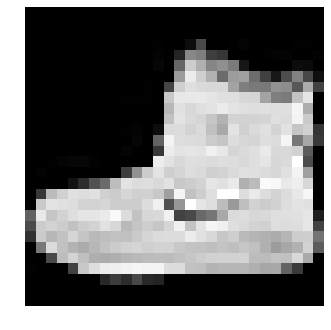

In [18]:
import matplotlib
matplotlib.rc('image', cmap = 'gray')
import matplotlib.pyplot as plt

# Setup the input variable x.
img, label = trainset[0]
x = img.view(1, 1 * 28 * 28)

# Setup the number of inputs, hidden neurons, and outputs.
nInputs = 1 * 28 * 28
nHidden = 512
nOutputs = 10

# Create the model here.
linear_fn1 = toynn_Linear(nInputs, nHidden)
relu_fn = toynn_ReLU()
linear_fn2 = toynn_Linear(nHidden, nOutputs)

# Make predictions.
a = linear_fn1.forward(x)
z = relu_fn.forward(a)
yhat = linear_fn2.forward(z)

# Show the prediction scores for each class.
# Yes, pytorch tensors already come with a softmax function.
# We need it here because we hard-coded the softmax inside 
# the loss function.
print(yhat.softmax(dim = 1)) 

plt.imshow(img[0]); plt.axis('off'); plt.grid(False)

Since the weights, and biases in the two linear layers [linear_fn1, linear_fn2] are not trained, the predictions are arbitrary at this point. One of the tasks for this assignment is for you to train the neural network.

## Assignment Questions [10pts + 3pts extra]

* **[3pts] ** Provide code for the following activation functions:

$$\text{Sigmoid(x)} = \frac{1}{1 + e^{-x}} = \frac{e^x}{e^x + 1}$$

$$\text{Tanh(x)} = \frac{e^{x} - e^{-x}}{e^{x} + e^{-x}}$$

$$ \text{LeakyReLU}(x) = \begin{cases} 
      0.01 x & x < 0 \\
      x & x \geq 0 
\end{cases}$$

In [0]:
import math
from math import exp

# Sigmoid of x.
class toynn_Sigmoid:
    def forward(self, x):
        # Forward pass.
        outputs = x.exp() / (x.exp() + 1)
        return outputs
    
    def backward(self, x, output_grads):
        # Backward pass
        inputs_grad = x.exp() / (x.exp() + 1) ** 2
        return inputs_grad * output_grads
        
# Hyperbolic tangent.
class toynn_Tanh:
    def forward(self, x):
        # Forward pass.
        outputs = x.exp() - (-x).exp() / (x.exp() + (-x).exp())
        return outputs
     
    def backward(self, x, output_grads):
        # Backward pass
        inputs_grad = 4 * (2*x).exp() / ((2*x).exp()+1)**2
        return inputs_grad * output_grads
      
# LeakyReLU of x.
class toynn_LeakyReLU:
    def forward(self, x):
        # Forward pass.
        outputs = x.clone()
        outputs[outputs < 0] = 0.01 * outputs
        return outputs
    
    def backward(self, x, output_grads):
        # Backward pass
        inputs_grad = output_grads.clone()
        inputs_grad[x < 0] *= 0.01
        return inputs_grad * output_grads

* **[2pts] ** Provide code for the binary cross entropy loss function:

$$\ell(y, \hat{y}) = -\sum_{i=1}^{i=n} [y_i\text{log}(\hat{y}_i) + (1 - y_i)\text{log}(1 - \hat{y}_i)]$$,

where $n$ is the number of outputs (e.g. the size of vectors $y$ and $\hat{y}$), the entries in the target vector $y_i$ are binary $\in \{0,1\}$ and $y_i$ are typically the outputs of a sigmoid layer. Remember that the backward pass does not return a scalar but a vector containing the values for $\partial \ell / \partial \hat{y}_i$, henceforth a vector of the same size as $\hat{y}$.

In [0]:
inn = torch.tensor([[2,3,4],[3,4,5]])
la = torch.tensor([[0,1,0],[1,0,0]])
inn_1 = inn.sum(1).repeat(inn.size(1), 1).t()
inn_2 = torch.mul(inn, 1/inn_1)
inn_3 = torch.gather(inn, 1, la.view(2, 3))
inn_3

2

In [0]:
class toynn_CrossEntropyLoss(object): 
  
    # Forward pass: -log softmax(input_{label})
    def forward(self, scores, labels):
      
        # 1. Computing the softmax: exp(x) / sum (exp(x))
        max_val = scores.max()  # This is to avoid variable overflows.
        exp_inputs = (scores - max_val).exp()
        # This is different than in the previous lab. Avoiding for loops here.
        denominators = exp_inputs.sum(1).repeat(scores.size(1), 1).t()
        self.predictions = torch.mul(exp_inputs, 1 / denominators)
        
        # 2. Computing the loss: -log(y_label).
        # Check what gather does. Just avoiding another for loop here.
        return -self.predictions.log().gather(1, labels.view(-1, 1)).mean()
    
    # Backward pass: y_hat - y
    def backward(self, scores, labels):
      
        # Here we avoid computing softmax again in backward pass.
        grad_inputs = self.predictions.clone()
        
        # Ok, Here we will use a for loop (but it is avoidable too).
        for i in range(0, scores.size(0)):
            grad_inputs[i][labels[i]] = grad_inputs[i][labels[i]] - 1
            
        return grad_inputs 

In [0]:
# Binary cross entropy loss. 
# Useful for classification when the classes are not mutually exclusive.
# For instance, when both shoe, and dress, are correct labels for an image.
# In other words, when images have multiple labels per image.

import math
from math import log

class toynn_BCELoss:
    def forward(self, predictions, targets):
        # Forward pass.
        # 1. Computing the softmax: exp(x) / sum (exp(x))
        max_val = predictions.max()  # This is to avoid variable overflows.
        exp_inputs = (predictions - max_val).exp()
        # This is different than in the previous lab. Avoiding for loops here.
        denominators = exp_inputs.sum(1).repeat(predictions.size(1), 1).t()
        scores = torch.mul(exp_inputs, 1 / denominators)
        for_output = torch.zeros([1, scores.size(0)])
        #for i in range(0, predictions.size(0)):
          #for j in range(0, predictions.size(1)):
          #for_output[i] = - (targets[i] * predictions[i].log() + (1 - targets[i]) * (1 - predictions[i].log()))
        for i in range(0, predictions.size(0)):
            currloss = 0
            for j in range(0, predictions.size(1)):
                 currloss += -(targets[i][j].item() * log(scores[i][j].item()) + (1 - targets[i][j].item()) * log(1 - scores[i][j].item()))
            for_output[0][i] = currloss
        return for_output.sum()
        
    def backward(self, predictions, targets):
        # Backward pass.
        inputs_grad = predictions.clone()
        for i in range(0, predictions.size(0)):
          for j in range(0, predictions.size(1)):
            inputs_grad[i][j] = -(targets[i][j].item() / inputs_grad[i][j].item()) - (1 - targets[i][j].item()) / (1 - inputs_grad[i][j].item()) 
        #for i in range(0, predictions.size(0)):
          
            #inputs_grad[i][j] = -(targets[i] / inputs_grad[i][j])
        return inputs_grad

* **[5pts] ** Train the two-layer Neural Network as defined in Section 3 of this Assignment on FashionMNIST using toynn. Include below the code for training this neural network and report the training, validation plots for loss and accuracy. The code should be similar to the code in Section 2 of this assignment, please follow that convention.

In [0]:
# Your code goes here.
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST

# Removes, the need to call F.to_image ourselves.
# Also, please look up what transforms.Normalize does.
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), 
                                                    (0.5, 0.5, 0.5))])

# Load the training, and validation datasets.
trainset = FashionMNIST(root = './data', train = True, transform = transform, download = True)
valset = FashionMNIST(root = './data', train = False, transform = transform, download = True)

# NEW: Pytorch DataLoader for iterating over batches.
batchSize = 100

# Shuffling is needed in case dataset is not shuffled by default.
train_loader = torch.utils.data.DataLoader(dataset = trainset,
                                           batch_size = batchSize,
                                           shuffle = True)
# We don't need to bach the validation set but let's do it anyway.
val_loader = torch.utils.data.DataLoader(dataset = valset,
                                         batch_size = batchSize,
                                         shuffle = False) # No need.

# Define a learning rate. 
learningRate = 1e-3

# Define number of epochs.
N = 6

# Create the model.
linear_fn1 = toynn_Linear(nInputs, nHidden)
relu_fn = toynn_ReLU()
linear_fn2 = toynn_Linear(nHidden, nOutputs)

# Setup the number of inputs, hidden neurons, and outputs.
nInputs = 1 * 28 * 28
nHidden = 512
nOutputs = 10

# log accuracies and losses.
train_accuracies = []; val_accuracies = []
train_losses = []; val_losses = []

# Training loop. Please make sure you understand every single line of code below.
# Go back to some of the previous steps in this lab if necessary.
for epoch in range(0, N):
    correct = 0.0
    cum_loss = 0.0
    
    # Make a pass over the training data.
    for (i, (inputs, labels)) in enumerate(train_loader):
        inputs = inputs.view(batchSize, 1 * 28 * 28)
        
        # Forward pass. (Prediction stage)
        a = linear_fn1.forward(inputs)
        z = relu_fn.forward(a)
        scores = linear_fn2.forward(z)
        cum_loss += loss_fn.forward(scores, labels).item()
        
        # Count how many correct in this batch.
        max_scores, max_labels = scores.max(1)
        correct += (max_labels == labels).sum().item()
        
        #Backward pass. (Gradient computation stage)
        scores_grads = loss_fn.backward(scores, labels)
        z_grads = linear_fn2.backward(z, scores_grads)
        a_grads = relu_fn.backward(a, z_grads)
        grad_inputs = linear_fn1.backward(inputs, a_grads)
        
        # Parameter updates (SGD step).
        linear_fn1.weight.add_(-learningRate, linear_fn1.weight_grads)
        linear_fn1.bias.add_(-learningRate, linear_fn1.bias_grads)
        
        # Logging the current results on training.
        if (i + 1) % 100 == 0:
            print('Train-epoch %d. Iteration %05d, Avg-Loss: %.4f, Accuracy: %.4f' % 
                  (epoch, i + 1, cum_loss / (i + 1), correct / (i * batchSize + 1)))
    
    train_accuracies.append(correct / len(trainset))
    train_losses.append(cum_loss / len(trainset))
    
    
    # Make a pass over the validation data.
    correct = 0.0
    cum_loss = 0.0
    for (i, (inputs, labels)) in enumerate(val_loader):
        inputs = inputs.view(batchSize, 1 * 28 * 28)
        
        # Forward pass. (Prediction stage)
        a = linear_fn1.forward(inputs)
        z = relu_fn.forward(a)
        scores = linear_fn2.forward(z)
        cum_loss += loss_fn.forward(scores, labels).item()
        
         # Count how many correct in this batch.
        max_scores, max_labels = scores.max(1)
        correct += (max_labels == labels).sum().item()
          
    val_accuracies.append(correct / len(valset))
    val_losses.append(cum_loss / (i + 1))
            
    # Logging the current results on validation.
    print('Validation-epoch %d. Avg-Loss: %.4f, Accuracy: %.4f' % 
          (epoch, cum_loss / (i + 1), correct / len(valset)))

Train-epoch 0. Iteration 00100, Avg-Loss: 1.5834, Accuracy: 0.6280
Train-epoch 0. Iteration 00200, Avg-Loss: 1.3005, Accuracy: 0.6763
Train-epoch 0. Iteration 00300, Avg-Loss: 1.1570, Accuracy: 0.6963
Train-epoch 0. Iteration 00400, Avg-Loss: 1.0646, Accuracy: 0.7090
Train-epoch 0. Iteration 00500, Avg-Loss: 0.9983, Accuracy: 0.7206
Train-epoch 0. Iteration 00600, Avg-Loss: 0.9476, Accuracy: 0.7296
Validation-epoch 0. Avg-Loss: 0.7002, Accuracy: 0.7674
Train-epoch 1. Iteration 00100, Avg-Loss: 0.6746, Accuracy: 0.7913
Train-epoch 1. Iteration 00200, Avg-Loss: 0.6624, Accuracy: 0.7897
Train-epoch 1. Iteration 00300, Avg-Loss: 0.6576, Accuracy: 0.7867
Train-epoch 1. Iteration 00400, Avg-Loss: 0.6483, Accuracy: 0.7880
Train-epoch 1. Iteration 00500, Avg-Loss: 0.6396, Accuracy: 0.7905
Train-epoch 1. Iteration 00600, Avg-Loss: 0.6325, Accuracy: 0.7922
Validation-epoch 1. Avg-Loss: 0.6142, Accuracy: 0.7944
Train-epoch 2. Iteration 00100, Avg-Loss: 0.5738, Accuracy: 0.8144
Train-epoch 2. Iter

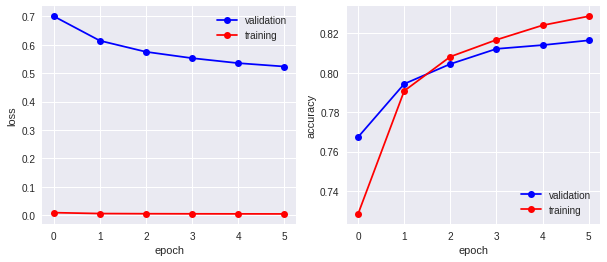

In [0]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
plt.plot(val_losses, 'bo-', label = 'val-loss')
plt.plot(train_losses, 'ro-', label = 'train-loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['validation', 'training'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, 'bo-', label = 'val-acc')
plt.plot(train_accuracies, 'ro-', label = 'train-acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['validation', 'training'], loc='lower right')
plt.show()

* **[3pts (extra)]** Train a Neural Network **using toynn** on the CIFAR 10 Dataset (torchvision.datasets.CIFAR10). Include the code for defining, and training the neural network, as well as plots for training, validation for loss and accuracy. Show the predictions for one example of this dataset. Write down below your code in bold face the accuracy you obtained and in how many epochs. I will post the highest accuracies that people obtained for this part.

In [199]:
# Your code goes here.
from torchvision.datasets import CIFAR10

transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), 
                                                    (0.5, 0.5, 0.5))])

# Load the training, and validation datasets.
trainset = CIFAR10(root = './data', train = True, transform = transform, download = True)
valset = CIFAR10(root = './data', train = False, transform = transform, download = True)

img, label = trainset[0]
img.shape

Files already downloaded and verified
Files already downloaded and verified


torch.Size([3, 32, 32])

In [213]:

# NEW: Pytorch DataLoader for iterating over batches.
batchSize = 100

# Shuffling is needed in case dataset is not shuffled by default.
train_loader = torch.utils.data.DataLoader(dataset = trainset,
                                           batch_size = batchSize,
                                           shuffle = True)
# We don't need to bach the validation set but let's do it anyway.
val_loader = torch.utils.data.DataLoader(dataset = valset,
                                         batch_size = batchSize,
                                         shuffle = False) # No need.

# Define a learning rate. 
learningRate = 1e-4

# Define number of epochs.
N = 10

# Setup the number of inputs, hidden neurons, and outputs.
nInputs = 3 * 32 * 32
nHidden = 512
nOutputs = 10

# Create the model.
linear_fn1 = toynn_Linear(nInputs, nHidden)
sig_fn = toynn_ReLU()
linear_fn2 = toynn_Linear(nHidden, nOutputs)

loss_fn = toynn_CrossEntropyLoss()

# log accuracies and losses.
train_accuracies = []; val_accuracies = []
train_losses = []; val_losses = []

# Training loop. Please make sure you understand every single line of code below.
# Go back to some of the previous steps in this lab if necessary.
for epoch in range(0, N):
    correct = 0.0
    cum_loss = 0.0
    
    # Make a pass over the training data.
    for (i, (inputs, labels)) in enumerate(train_loader):
        inputs = inputs.view(batchSize, 3 * 32 * 32)
        
        # Forward pass. (Prediction stage)
        a = linear_fn1.forward(inputs)
        z = sig_fn.forward(a)
        scores = linear_fn2.forward(z)
        #onehot = torch.zeros([scores.size(0), scores.size(1)])
        #for j in range(0, scores.size(0)):
          #onehot[j][labels[j]] = 1
        cum_loss += loss_fn.forward(scores, labels).item()
        
        # Count how many correct in this batch.
        max_scores, max_labels = scores.max(1)
        correct += (max_labels == labels).sum().item()
        
        #Backward pass. (Gradient computation stage)
        score_grads = loss_fn.backward(scores, labels)
        z_grads = linear_fn2.backward(z, score_grads)
        a_grads = sig_fn.backward(a, z_grads)
        input_grades = linear_fn1.backward(inputs, a_grads)
        
        # Parameter updates (SGD step).
        linear_fn1.weight.add_(-learningRate, linear_fn1.weight_grads)
        linear_fn1.bias.add_(-learningRate, linear_fn1.bias_grads)
        #linear_fn2.weight.add(-learningRate, linear_fn2.weight_grads)
        #linear_fn2.bias.add_(-learningRate, linear_fn2.bias_grads)
        
        # Logging the current results on training.
        #if (i + 1) % 100 == 0:
            #print('Train-epoch %d. Iteration %05d, Avg-Loss: %.4f, Accuracy: %.4f' % 
                  #(epoch, i + 1, cum_loss / (i + 1), correct / (i * batchSize + 1)))
    
    train_accuracies.append(correct / len(trainset))
    train_losses.append(cum_loss / len(trainset))
    
    
    # Make a pass over the validation data.
    correct = 0.0
    cum_loss = 0.0
    for (i, (inputs, labels)) in enumerate(val_loader):
        inputs = inputs.view(batchSize, 3 * 32 * 32)
        
        # Forward pass. (Prediction stage)
        a = linear_fn1.forward(inputs)
        z = sig_fn.forward(a)
        scores = linear_fn2.forward(z)
        cum_loss += loss_fn.forward(scores, labels).item()
        
         # Count how many correct in this batch.
        max_scores, max_labels = scores.max(1)
        correct += (max_labels == labels).sum().item()
          
    val_accuracies.append(correct / len(valset))
    val_losses.append(cum_loss / (i + 1))
            
    # Logging the current results on validation.
    print('Validation-epoch %d. Avg-Loss: %.4f, Accuracy: %.4f' % 
          (epoch, cum_loss / (i + 1), correct / len(valset)))

Validation-epoch 0. Avg-Loss: 2.0983, Accuracy: 0.2778
Validation-epoch 1. Avg-Loss: 2.0136, Accuracy: 0.3072
Validation-epoch 2. Avg-Loss: 1.9600, Accuracy: 0.3279
Validation-epoch 3. Avg-Loss: 1.9214, Accuracy: 0.3431
Validation-epoch 4. Avg-Loss: 1.8914, Accuracy: 0.3540
Validation-epoch 5. Avg-Loss: 1.8672, Accuracy: 0.3626
Validation-epoch 6. Avg-Loss: 1.8473, Accuracy: 0.3678
Validation-epoch 7. Avg-Loss: 1.8303, Accuracy: 0.3733
Validation-epoch 8. Avg-Loss: 1.8157, Accuracy: 0.3771
Validation-epoch 9. Avg-Loss: 1.8026, Accuracy: 0.3822


### **I obtained a validation accuracy of 38% after 10 epochs.**